# Figure 4D
## *in vivo* vs. *ex vivo* propagation

For "Network-level encoding of local neurotransmitters in cortical astrocytes" (Cahill et al. 2024)

---

## Setup

#### Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils
import uncaging.events as uevents

import aqua.stats as astats

In [2]:
params_dir = Path( 'config' ) / 'panels'

params = uutils.load_params( params_dir / 'net_astro-4d-common.yaml' )

analysis_params = dict()
for analysis, path_spec in params['analysis_params_filenames'].items():
    path = uutils._render_yaml_path( path_spec )
    analysis_params[analysis] = uutils.load_params( path )

In [3]:
helper = Helper( config_path = params['helper_configs'],
                 hive_root = params['hive_root'],
                 output_to = params['output_parent'] )

analysis_helpers = { analysis: Helper( config_path = cur_params['helper_configs'],
                                       hive_root = cur_params['hive_root'] )
                     for analysis, cur_params in analysis_params.items() }

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']
analysis_name = '-vs-'.join( params['analyses'] )

save_figure = helper.figure_saver( notebook_stem, analysis )
save_data = helper.data_saver( notebook_stem, analysis )
save_csv = helper.csv_saver( notebook_stem, analysis )

---

## Load data

In [4]:
analysis_events = dict()
for analysis in params['analyses']:
    print( f'** Loading analysis: {analysis}' )
    analysis_events[analysis] = analysis_helpers[analysis].load_analysis_events(
        analysis,
        extra_decorators = [],
        verbose = True
    )
    print()

** Loading analysis: invivo


Loading 20190624_MRAcytoNGi(5)_Saline_nl_2x_149um_reg_gcampwLEP_30min_Post_net-events.mat...: 100%|██████████| 30/30 [00:07<00:00,  3.84it/s]                 



** Loading analysis: wt


Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 25.38it/s] 
Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 24.47it/s] 
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:01<00:00, 30.45it/s]



Experiment Glu
    Excluded cells: 177
    Included cells: 138


Experiment GABA
    Excluded cells: 154
    Included cells: 164


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99


** Loading analysis: cx43


Loading 20210709_CytoGRFPCx43flp32f_S2_RuBiGlu3_10st-021Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 124/124 [00:03<00:00, 32.34it/s]  
Loading 20210709_CytoGRFPCx43flp32f_S2_RuBiGlu3_10st-021Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 124/124 [00:03<00:00, 35.21it/s]  
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:01<00:00, 38.19it/s]



Experiment Cx43-Glu
    Excluded cells: 563
    Included cells: 65


Experiment Cx43-GABA
    Excluded cells: 578
    Included cells: 83


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99




In [5]:
# TODO: This step is only needed in order to compute 'mark_propTotal'
for cur_analysis, cur_events in analysis_events.items():
    analysis_events[cur_analysis], _, _ = uevents.split_events_prop(
        cur_events,
        threshold = params['prop']['threshold']
    )

---

## Analysis

### Compare fractions of propagative events

#### Capture correct subsets of events

In [6]:
events_compare = dict()

for cur_analysis, cur_events in analysis_events.items():
    
    cur_params = analysis_params[cur_analysis]

    filter_cur = np.array( [ True for _ in range( cur_events.shape[0] ) ] )

    if 'subset_window' in cur_params:
        filter_cur = filter_cur & uevents.is_within( cur_events['start_time_rel'], cur_params['subset_window'] )

    if 'subset_filters' in cur_params:
        for filter_key, filter_value in cur_params['subset_filters'].items():
            if type( filter_value ) == list:
                filter_cur = filter_cur & cur_events[filter_key].isin( filter_value )
                continue
            if type( filter_value ) == str:
                if filter_value.startswith( '$>' ):
                    threshold_value = float( filter_value.split( '$>' )[1].strip() )
                    filter_cur = filter_cur & (cur_events[filter_key] > threshold_value)
                    continue
            
            # All other filtervalues
            filter_cur = filter_cur & (cur_events[filter_key] == filter_value)
    
    events_compare[cur_analysis] = cur_events[filter_cur]

#### Characterize $n$

TODO: Use more generalized function

In [7]:
for k, es in events_compare.items():
    print( f'**** Analysis: "{k}"')
    uevents.summarize_n( es )
    print()

**** Analysis: "invivo"
Mice:            n = 5
Datasets:        n = 15
Events:          n = 17414
Datasets per mouse:
    Low:  3
    High: 3

**** Analysis: "wt"
Mice:            n = 4
Slices:          n = 7
Datasets:        n = 55
Cell-recordings: n = 262
Cells:           n = 174
Events:          n = 3581
Slices per mouse:
    Low:  1
    High: 2
Datasets per mouse:
    Low:  8
    High: 16
Datasets per slice:
    Low:  7
    High: 8
Cells per dataset:
    Low:  1
    High: 13
Events per cell-recording:
    Low:  3
    High: 65

** GABA:
Datasets:        n = 28
Cell-recordings: n = 142
Events:          n = 1987
Cells per dataset:
    Low:  2
    High: 13

** Glu:
Datasets:        n = 27
Cell-recordings: n = 120
Events:          n = 1594
Cells per dataset:
    Low:  1
    High: 7

**** Analysis: "cx43"
Mice:            n = 8
Slices:          n = 14
Datasets:        n = 51
Cell-recordings: n = 107
Cells:           n = 86
Events:          n = 769
Slices per mouse:
    Low:  1
    High: 

In [8]:
prop_key = params['prop']['key']
prop_threshold = params['prop']['threshold']
group_key = params['stats']['prop_fraction']['group_key']
n_boot = params['stats']['prop_fraction']['n_boot']

analysis_group_stats = dict()
analysis_stat = dict()
analysis_stat_boot = dict()
analysis_stat_se = dict()

stat = np.nanmedian

for analysis, cur_events in events_compare.items():
    cur_results = dict()
    cur_results['group'] = []
    cur_results['prop_fraction'] = []

    for group, df_group in cur_events.groupby( group_key ):
        filter_prop = df_group[prop_key] >= prop_threshold
        cur_prop_fraction = np.sum( filter_prop ) / df_group.shape[0]

        cur_results['group'].append( group )
        cur_results['prop_fraction'].append( cur_prop_fraction )

    cur_df = pd.DataFrame( cur_results )
    analysis_group_stats[analysis] = cur_df

    cur_xs = np.array( cur_df['prop_fraction'] )

    cur_stat = stat( cur_xs )
    cur_stat_boot = astats.boot_stat( cur_xs, stat, n = n_boot )
    cur_stat_se = np.std( cur_stat_boot )

    analysis_stat[analysis] = cur_stat
    analysis_stat_boot[analysis] = cur_stat_boot
    analysis_stat_se[analysis] = cur_stat_se


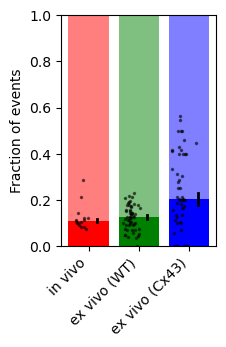

In [9]:
plt.figure( figsize = (2, 3) )

analysis_colors = params['plotting']['analysis_colors']
analysis_names = params['plotting']['analysis_names']
plot_params = params['plotting']['prop_fraction']

xticks = []
xticklabels = []
for i, analysis in enumerate( params['analyses'] ):

    cur_color = analysis_colors[analysis]
    cur_group_stats = analysis_group_stats[analysis]
    cur_stat = analysis_stat[analysis]
    cur_stat_se = analysis_stat_se[analysis]
    cur_stat_low = cur_stat - cur_stat_se
    cur_stat_high = cur_stat + cur_stat_se

    # Bars
    plt.bar( i, cur_stat,
            color = cur_color )
    plt.bar( i, 1. - cur_stat,
            bottom = cur_stat,
            color = cur_color,
            alpha = plot_params['bar_off_alpha'] )
    
    # Lines
    x_cur = i + plot_params['line_offset']
    plt.plot( [x_cur, x_cur], [cur_stat_low, cur_stat_high],
              'k-',
              linewidth = plot_params['line_width'] )

    # Dots
    ys_cur = np.array( cur_group_stats['prop_fraction'] )
    xs_cur = i + plot_params['dots_offset'] + plot_params['dots_noise'] * np.random.normal( size = ys_cur.shape )
    plt.plot( xs_cur, ys_cur,
              'k.',
              alpha = plot_params['dots_alpha'],
              markersize = plot_params['dots_markersize'] )
    
    xticks.append( i )
    xticklabels.append( analysis_names[analysis] )

plt.xticks( xticks, xticklabels,
            rotation = 45,
            horizontalalignment = 'right' )
plt.ylabel( 'Fraction of events' )

plt.ylim( 0, 1 )

save_figure( 'group_prop_fractions' )

plt.show()

In [10]:
analysis_names = params['plotting']['analysis_names']

for comparison in params['comparisons']:
    
    print( f'{analysis_names[comparison[0]]} vs. {analysis_names[comparison[1]]}:' )

    xs_0 = np.array( analysis_group_stats[comparison[0]]['prop_fraction'] )
    xs_1 = np.array( analysis_group_stats[comparison[1]]['prop_fraction'] )
    result = scipy.stats.ranksums( xs_0, xs_1 )

    print( f'    {result}' )

in vivo vs. ex vivo (WT):
    RanksumsResult(statistic=-0.5725250135716105, pvalue=0.5669663447598846)
ex vivo (WT) vs. ex vivo (Cx43):
    RanksumsResult(statistic=-4.261791490673905, pvalue=2.0279461506338198e-05)
